In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [71]:
import os,sys,glob,shutil
import numpy as np
import pandas as pd
import geopandas as gpd
import cv2
import matplotlib.pyplot as plt
from pygeotools.lib import geolib,warplib,malib,iolib
from imview import pltlib
from skysat_stereo import skysat
from scipy.spatial.transform import Rotation as R
from skysat_stereo import asp_utils as asp

from shapely import wkt
from shapely.geometry.polygon import orient

In [3]:
%cd /nobackup/sbhusha1/change/s108_20210406T040909Z/

/nobackupp11/sbhusha1/change/s108_20210406T040909Z


In [4]:
fn = 'frame_index.csv'

In [6]:
frame_index = skysat.parse_frame_index(fn,True)

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [8]:
frame_index.head(2)

,name,datetime,gsd,sat_az,sat_elev,x_sat_eci_km,y_sat_eci_km,z_sat_eci_km,qw_eci,qx_eci,...,y_sat_ecef_km,z_sat_ecef_km,qw_ecef,qx_ecef,qy_ecef,qz_ecef,bit_dpth,geom,integration_time_ms,filename
0,1301717367.65046096_sc00108_c3_PAN,2021-04-06T04:09:09.650461+00:00,1.124777,43.757951,54.626309,5446.94887,3118.34934,-2698.79223,0.653283,0.373069,...,4588.27493,-2687.66720,0.215369,-0.712615,0.088349,-0.661809,16,"POLYGON ((131.075182669813 -25.252703375099,13...",0.52316,1301717367.65046096_sc00108_c3_PAN_i0000000000...
1,1301717367.65046573_sc00108_c2_PAN,2021-04-06T04:09:09.650466+00:00,1.135013,43.555569,54.168736,5446.94886,3118.34933,-2698.79227,0.653283,0.373069,...,4588.27492,-2687.66724,0.215369,-0.712615,0.088349,-0.661809,16,"POLYGON ((131.04976305695 -25.2915903643759,13...",0.52316,1301717367.65046573_sc00108_c2_PAN_i0000000000...


In [30]:
def modernize_frame_index(frame_index_fn,return_frame_index=True,outfn=None):
    """
    Update frame_index to what ASP understands
    Update name columns and geometry columns
    
    Parameters
    -------------
    frame_index_fn: string
        path to frame_index
    outfn (Optional): string
        path to output frame_index filename
    """
    def _correct_geom(row):
        return wkt.loads(row['geom'])
    frame_index = pd.read_csv(frame_index_fn)
    frame_index['geom'] = frame_index.apply(_correct_geom,axis=1)
    
    # orient the Polygon geometry
    
    updated_geomlist_asp_convention = [orient(test_geom,-1) for test_geom in frame_index['geom'].values]
    # remove the space between POLYGON and ((# 
    updated_geomlist_asp_convention = [f"POLYGON(({str(test_geom).split(' ((')[1]}" for test_geom in updated_geomlist_asp_convention]
    
    # remove the repeated last coordinate
    updated_geomlist_asp_convention = [','.join(test_geom.split(',')[:-1])+'))' for test_geom in updated_geomlist_asp_convention]
    
    # update geometry column
    frame_index['geom'] = updated_geomlist_asp_convention
    
    # update name
    frame_index['name'] = [os.path.splitext(name)[0] for name in frame_index.filename.values]
    print(os.path.splitext(frame_index.filename.values[0])[0])
    # writeout
    if not outfn:
        outfn = os.path.splitext(frame_index_fn)[0] + '_with_orient.csv'
    frame_index.to_csv(outfn,index=False)
    
    if return_frame_index:
        return frame_index
    
    

In [9]:
def correct_geom(row):
    return wkt.loads(row['geom'])

In [13]:
frame_index['geom'] = frame_index.apply(correct_geom,axis=1)

In [16]:
print(frame_index['geom'].values[0])

POLYGON ((131.075182669813 -25.252703375099, 131.075086503775 -25.2420213590524, 131.046827540786 -25.2474006834797, 131.046927861518 -25.2580848603599, 131.075182669813 -25.252703375099))


In [18]:
updated_geomlist_asp_convention = frame_index['geom'].values

In [21]:
updated_geomlist_asp_convention = [f"POLYGON(({str(test_geom).split(' ((')[1]}" for test_geom in updated_geomlist_asp_convention]

In [23]:
updated_geomlist_asp_convention = [','.join(test_geom.split(',')[:-1])+'))' for test_geom in updated_geomlist_asp_convention]

In [25]:
frame_index_opt1 = skysat.parse_frame_index(fn,True)
frame_index_opt1_fn = os.path.splitext(fn)[0]+'_without_orient.csv'

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [26]:
frame_index_opt1['geom'] = updated_geomlist_asp_convention

In [28]:
frame_index_opt1['name'] = frame_index_opt1['filename']

In [29]:
frame_index_opt1.to_csv(frame_index_opt1_fn,index=False)

In [59]:
! ls

fontconfig	 frame_index_with_orient.csv	 isce.log    out
frame_index.csv  frame_index_without_orient.csv  l1a_frames  test


### With orient

In [61]:
frame_index_opt2 = skysat.parse_frame_index(fn,True)
frame_index_opt2_fn = os.path.splitext(fn)[0]+'_with_orient.csv'
frame_index_opt2['geom'] = frame_index_opt2.apply(correct_geom,axis=1)

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [62]:
print(frame_index_opt2['geom'].values[0])

POLYGON ((131.075182669813 -25.252703375099, 131.075086503775 -25.2420213590524, 131.046827540786 -25.2474006834797, 131.046927861518 -25.2580848603599, 131.075182669813 -25.252703375099))


In [63]:
updated_geomlist_asp_convention = [orient(test_geom,-1) for test_geom in frame_index_opt2['geom'].values]

In [64]:
print(updated_geomlist_asp_convention[0])

POLYGON ((131.075182669813 -25.252703375099, 131.046927861518 -25.2580848603599, 131.046827540786 -25.2474006834797, 131.075086503775 -25.2420213590524, 131.075182669813 -25.252703375099))


In [65]:
updated_geomlist_asp_convention = [f"POLYGON(({str(test_geom).split(' ((')[1]}" for test_geom in updated_geomlist_asp_convention]

In [66]:
print(updated_geomlist_asp_convention[0])

POLYGON((131.075182669813 -25.252703375099, 131.046927861518 -25.2580848603599, 131.046827540786 -25.2474006834797, 131.075086503775 -25.2420213590524, 131.075182669813 -25.252703375099))


In [67]:
updated_geomlist_asp_convention = [','.join(test_geom.split(',')[:-1])+'))' for test_geom in updated_geomlist_asp_convention]

In [68]:
print(updated_geomlist_asp_convention[0])

POLYGON((131.075182669813 -25.252703375099, 131.046927861518 -25.2580848603599, 131.046827540786 -25.2474006834797, 131.075086503775 -25.2420213590524))


In [69]:
frame_index_opt2['geom'] = updated_geomlist_asp_convention

In [70]:
frame_index_opt2.head(2)

,name,datetime,gsd,sat_az,sat_elev,x_sat_eci_km,y_sat_eci_km,z_sat_eci_km,qw_eci,qx_eci,...,y_sat_ecef_km,z_sat_ecef_km,qw_ecef,qx_ecef,qy_ecef,qz_ecef,bit_dpth,geom,integration_time_ms,filename
0,1301717367.65046096_sc00108_c3_PAN,2021-04-06T04:09:09.650461+00:00,1.124777,43.757951,54.626309,5446.94887,3118.34934,-2698.79223,0.653283,0.373069,...,4588.27493,-2687.66720,0.215369,-0.712615,0.088349,-0.661809,16,"POLYGON((131.075182669813 -25.252703375099, 13...",0.52316,1301717367.65046096_sc00108_c3_PAN_i0000000000...
1,1301717367.65046573_sc00108_c2_PAN,2021-04-06T04:09:09.650466+00:00,1.135013,43.555569,54.168736,5446.94886,3118.34933,-2698.79227,0.653283,0.373069,...,4588.27492,-2687.66724,0.215369,-0.712615,0.088349,-0.661809,16,"POLYGON((131.04976305695 -25.2915903643759, 13...",0.52316,1301717367.65046573_sc00108_c2_PAN_i0000000000...


In [71]:
updated_geomlist_asp_convention[0]

'POLYGON((131.075182669813 -25.252703375099, 131.046927861518 -25.2580848603599, 131.046827540786 -25.2474006834797, 131.075086503775 -25.2420213590524))'

In [72]:
frame_index_opt2['name'] = frame_index_opt2['filename']

In [73]:
frame_index_opt2.to_csv(frame_index_opt2_fn,index=False)

In [74]:
## Get AOI for reference DEMs

In [75]:
! ls

fontconfig	 frame_index_with_orient.csv	 isce.log    out
frame_index.csv  frame_index_without_orient.csv  l1a_frames  test


### Get bounds for fetching DEM on batComputer

In [76]:
skysat.parse_frame_index(fn).total_bounds

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


array([130.99536167, -25.47722607, 131.07518267, -25.24202136])

### Get frame_index for only c2

In [77]:
frame_list = sorted(glob.glob('l1a_frames/*c2*.tif'))

In [78]:

frame_base = [os.path.basename(frame) for frame in frame_list]
mask = frame_index_opt2['filename'].isin(frame_base)
frame_index_c2 = frame_index_opt2[mask]

In [79]:
frame_index_opt2_c2_fn = os.path.splitext(fn)[0]+'_with_orient_c2.csv'

In [90]:
os.path.splitext(frame_index_c2['name'].values[0])[0]

'1301717367.65046573_sc00108_c2_PAN_i0000000000'

In [91]:
frame_index_c2['name'] = [os.path.splitext(name)[0] for name in frame_index_c2.name.values]

<ipython-input-91-52af9d909d49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_index_c2['name'] = [os.path.splitext(name)[0] for name in frame_index_c2.name.values]


In [92]:
frame_index_c2.head(2).name.values

array(['1301717367.65046573_sc00108_c2_PAN_i0000000000',
       '1301717367.67254806_sc00108_c2_PAN_i0000000001'], dtype=object)

In [93]:
frame_index_c2.to_csv(frame_index_opt2_c2_fn,index=False)

### Generate cameras as 
`skysat_preprocess.py -mode video -t pinhole -img processing/c2/ -sampler 306 -outdir processing/camera_camgen/ -frame_index frame_index_with_orient_c2.csv -dem $refdem -product_level l1a`

In [95]:
frame_index_c2.name.values[8]

'1301717367.82759547_sc00108_c2_PAN_i0000000008'

### Evaluate disparity from original cameras

<AxesSubplot:>

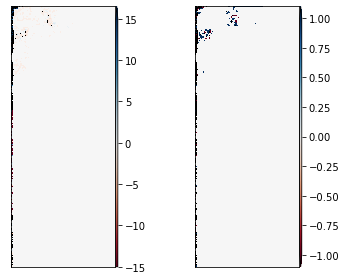

In [104]:
disparity = 'processing/c2_first2_rpc/run-D.tif'
dx,dy  = [iolib.fn_getma(disparity,i) for i in range(1,3)]
f,ax = plt.subplots(1,2)
pltlib.iv(dx,ax=ax[0],cmap='RdBu',clim=malib.calcperc_sym(dx))
pltlib.iv(dy,ax=ax[1],cmap='RdBu',clim=malib.calcperc_sym(dy))

In [101]:
malib.get_stats_dict(dx)

{'count': 2592287,
 'min': -15.0,
 'max': 23.0,
 'ptp': 38.0,
 'mean': -0.05425363781093683,
 'std': 1.0992474135577537,
 'nmad': 0.0,
 'med': 0.0,
 'median': 0.0,
 'p16': 0.0,
 'p84': 0.0,
 'spread': 0.0,
 'mode': 0.0}

In [102]:
malib.get_stats_dict(dy)

{'count': 2581377,
 'min': -4.0,
 'max': 4.0,
 'ptp': 8.0,
 'mean': 0.0037049993085085985,
 'std': 0.12830423093875531,
 'nmad': 0.0,
 'med': 0.0,
 'median': 0.0,
 'p16': 0.0,
 'p84': 0.0,
 'spread': 0.0,
 'mode': 0.0}

#### After affine-epipolar alignment, there is not any disparity in the x and y direction.

<AxesSubplot:>

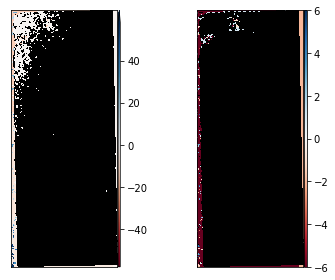

In [107]:
disparity = 'processing/c2_first2_pinholeasp/run-D.tif'
dx,dy  = [iolib.fn_getma(disparity,i) for i in range(1,3)]
f,ax = plt.subplots(1,2)
pltlib.iv(dx,ax=ax[0],cmap='RdBu',clim=malib.calcperc_sym(dx))
pltlib.iv(dy,ax=ax[1],cmap='RdBu',clim=malib.calcperc_sym(dy))

In [111]:
frame_index_c2.head(2)

,name,datetime,gsd,sat_az,sat_elev,x_sat_eci_km,y_sat_eci_km,z_sat_eci_km,qw_eci,qx_eci,...,y_sat_ecef_km,z_sat_ecef_km,qw_ecef,qx_ecef,qy_ecef,qz_ecef,bit_dpth,geom,integration_time_ms,filename
1,1301717367.65046573_sc00108_c2_PAN_i0000000000,2021-04-06T04:09:09.650466+00:00,1.135013,43.555569,54.168736,5446.94886,3118.34933,-2698.79227,0.653283,0.373069,...,4588.27492,-2687.66724,0.215369,-0.712615,0.088349,-0.661809,16,"POLYGON((131.04976305695 -25.2915903643759, 13...",0.52316,1301717367.65046573_sc00108_c2_PAN_i0000000000...
4,1301717367.67254806_sc00108_c2_PAN_i0000000001,2021-04-06T04:09:09.672548+00:00,1.134851,43.562772,54.176972,5446.90313,3118.29668,-2698.94581,0.653341,0.373022,...,4588.24975,-2687.82088,0.215390,-0.712554,0.088362,-0.661865,16,"POLYGON((131.049760248284 -25.2921811831888, 1...",0.46002,1301717367.67254806_sc00108_c2_PAN_i0000000001...


In [113]:
frame_index_c2[['x_sat_ecef_km','y_sat_ecef_km','z_sat_ecef_km']]

,x_sat_ecef_km,y_sat_ecef_km,z_sat_ecef_km
1,-4289.64010,4588.27492,-2687.66724
4,-4289.57102,4588.24975,-2687.82088
6,-4289.50184,4588.22453,-2687.97475
9,-4289.43264,4588.19931,-2688.12863
12,-4289.36345,4588.17409,-2688.28250
...,...,...,...
904,-4268.70025,4580.54902,-2733.91167
906,-4268.63031,4580.52290,-2734.06504
911,-4268.56033,4580.49677,-2734.21848
914,-4268.49038,4580.47064,-2734.37185


In [117]:
def total_offset(row):
    return np.sqrt((row['x_sat_ecef_km']**2+row['y_sat_ecef_km']**2+row['z_sat_ecef_km']**2))*1000

In [119]:
frame_index_c2['total_cam_offset'] = frame_index_c2[['x_sat_ecef_km','y_sat_ecef_km','z_sat_ecef_km']].diff().apply(total_offset,axis=1)

<ipython-input-119-e8b59fc7deee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_index_c2['total_cam_offset'] = frame_index_c2[['x_sat_ecef_km','y_sat_ecef_km','z_sat_ecef_km']].diff().apply(total_offset,axis=1)


In [120]:
frame_index_c2.head()

,name,datetime,gsd,sat_az,sat_elev,x_sat_eci_km,y_sat_eci_km,z_sat_eci_km,qw_eci,qx_eci,...,z_sat_ecef_km,qw_ecef,qx_ecef,qy_ecef,qz_ecef,bit_dpth,geom,integration_time_ms,filename,total_cam_offset
1,1301717367.65046573_sc00108_c2_PAN_i0000000000,2021-04-06T04:09:09.650466+00:00,1.135013,43.555569,54.168736,5446.94886,3118.34933,-2698.79227,0.653283,0.373069,...,-2687.66724,0.215369,-0.712615,0.088349,-0.661809,16,"POLYGON((131.04976305695 -25.2915903643759, 13...",0.52316,1301717367.65046573_sc00108_c2_PAN_i0000000000...,NaN
4,1301717367.67254806_sc00108_c2_PAN_i0000000001,2021-04-06T04:09:09.672548+00:00,1.134851,43.562772,54.176972,5446.90313,3118.29668,-2698.94581,0.653341,0.373022,...,-2687.82088,0.215390,-0.712554,0.088362,-0.661865,16,"POLYGON((131.049760248284 -25.2921811831888, 1...",0.46002,1301717367.67254806_sc00108_c2_PAN_i0000000001...,170.325644
6,1301717367.69466472_sc00108_c2_PAN_i0000000002,2021-04-06T04:09:09.694665+00:00,1.134703,43.569988,54.185219,5446.85732,3118.24395,-2699.09959,0.653398,0.372975,...,-2687.97475,0.215412,-0.712494,0.088375,-0.661921,16,"POLYGON((131.049764812089 -25.2927659348767, 1...",0.46002,1301717367.69466472_sc00108_c2_PAN_i0000000002...,170.581059
9,1301717367.71678233_sc00108_c2_PAN_i0000000003,2021-04-06T04:09:09.716782+00:00,1.134540,43.577207,54.193467,5446.81151,3118.19121,-2699.25338,0.653455,0.372928,...,-2688.12863,0.215434,-0.712434,0.088388,-0.661978,16,"POLYGON((131.049773684881 -25.2933467270526, 1...",0.46002,1301717367.71678233_sc00108_c2_PAN_i0000000003...,170.598191
12,1301717367.73889995_sc00108_c2_PAN_i0000000004,2021-04-06T04:09:09.738900+00:00,1.134323,43.584427,54.201714,5446.76570,3118.13847,-2699.40715,0.653513,0.372881,...,-2688.28250,0.215455,-0.712373,0.088400,-0.662034,16,"POLYGON((131.04977682712 -25.2939331452357, 13...",0.46002,1301717367.73889995_sc00108_c2_PAN_i0000000004...,170.585115


In [126]:
! ls

fontconfig		     frame_index_with_orient_c2.csv  l1a_frames
frame_index.csv		     frame_index_without_orient.csv  processing
frame_index_with_orient.csv  isce.log			     refdem


### Initialise camera using RPC model and camgen

In [121]:
from p_tqdm import p_map

In [124]:
product_level = 'l1a'
outdir = 'processing/camera_camgen_rpc/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
dem = 'refdem/change_uluru_srtm.tif'

In [127]:
img_list = sorted(glob.glob('processing/c2/*.tiff'))
img_list = [os.path.splitext(os.path.basename(img))[0] for img in img_list]
cam_list = [glob.glob(os.path.join('processing/c2/','{}*.tiff'.format(img)))[0] for img in img_list]
n = len(img_list)
if product_level == 'l1b':
    pitch = [0.8]*n
else:
    pitch = [1.0]*n
out_fn = [os.path.join(outdir,'{}_rpc.tsai'.format(frame)) for frame in img_list]
out_gcp = [os.path.join(outdir,'{}_rpc.gcp'.format(frame)) for frame in img_list]
camera = cam_list
frame_index = [None]*n
img_list = cam_list
gcp_factor = 8
fl = [553846.153846]*n
cx = [1280]*n
cy = [540]*n
dem = dem
ht_datum = [malib.get_stats_dict(iolib.fn_getma(dem))['median']]*n # use this value for height where DEM has no-data
gcp_std = [1]*n
datum = ['WGS84']*n
refdem = [dem]*n
n_proc = 20
#n_proc = cpu_count()
cam_gen_log = p_map(asp.cam_gen,img_list,fl,cx,cy,pitch,ht_datum,gcp_std,out_fn,out_gcp,datum,refdem,camera,frame_index,num_cpus = n_proc)
print("writing gcp with basename removed")
# count expexted gcp 
print(f"Total expected GCP {gcp_factor*n}")    
asp.clean_gcp(out_gcp,outdir)


  0%|          | 0/306 [00:00<?, ?it/s]

writing gcp with basename removed
Total expected GCP 2448
Total number of GCPs found 2447


In [129]:
camera_folder,gcp_folder = outdir,outdir

In [130]:
[glob.glob(os.path.join(camera_folder,'*{}*.tsai'.format(os.path.basename(frame))))[0] for frame in frame_index_c2['name'].values]

IndexError: list index out of range

In [132]:
frame_index_c2['name'].values[0]

'1301717367.65046573_sc00108_c2_PAN_i0000000000'

In [137]:
test = (os.path.join(camera_folder,'*{}*.tsai'.format(os.path.basename(frame_index_c2['name'].values[0]))))

In [138]:
! ls $test

processing/camera_camgen_rpc/1301717367.65046573_sc00108_c2_PAN_i0000000000_rpc.tsai


In [140]:
len(sorted(glob.glob('processing/camera_camgen_rpc/*.tsai')))

292

### Check with scipy camera

/nobackupp11/sbhusha1/sw/imview/imview/lib/pltlib.py:149: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad('k', alpha=1)


<AxesSubplot:>

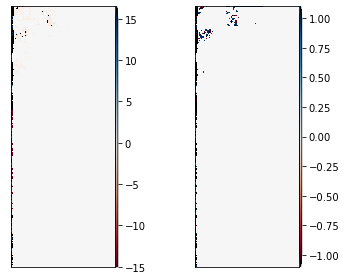

In [141]:
disparity = 'processing/c2_first2_pinholeasp_scipy/run-D.tif'
dx,dy  = [iolib.fn_getma(disparity,i) for i in range(1,3)]
f,ax = plt.subplots(1,2)
pltlib.iv(dx,ax=ax[0],cmap='RdBu',clim=malib.calcperc_sym(dx))
pltlib.iv(dy,ax=ax[1],cmap='RdBu',clim=malib.calcperc_sym(dy))

In [6]:
### Correct frame_index's

In [28]:
for_frame_fn = 'frame_index.csv'
nadir_frame_fn = '../s108_20210406T040941Z/frame_index.csv'
aft_frame_fn = '../s108_20210406T041015Z/frame_index.csv'

In [31]:
for_frame = modernize_frame_index(for_frame_fn)

1301717367.65046096_sc00108_c3_PAN_i0000000000


In [13]:
for_frame.head(2)

,name,datetime,gsd,sat_az,sat_elev,x_sat_eci_km,y_sat_eci_km,z_sat_eci_km,qw_eci,qx_eci,...,y_sat_ecef_km,z_sat_ecef_km,qw_ecef,qx_ecef,qy_ecef,qz_ecef,bit_dpth,geom,integration_time_ms,filename
0,1301717367.65046096_sc00108_c3_PAN_i0000000000,2021-04-06T04:09:09.650461+00:00,1.124777,43.757951,54.626309,5446.94887,3118.34934,-2698.79223,0.653283,0.373069,...,4588.27493,-2687.66720,0.215369,-0.712615,0.088349,-0.661809,16,"POLYGON((131.075182669813 -25.252703375099, 13...",0.52316,1301717367.65046096_sc00108_c3_PAN_i0000000000...
1,1301717367.65046573_sc00108_c2_PAN_i0000000000,2021-04-06T04:09:09.650466+00:00,1.135013,43.555569,54.168736,5446.94886,3118.34933,-2698.79227,0.653283,0.373069,...,4588.27492,-2687.66724,0.215369,-0.712615,0.088349,-0.661809,16,"POLYGON((131.04976305695 -25.2915903643759, 13...",0.52316,1301717367.65046573_sc00108_c2_PAN_i0000000000...


In [14]:
nadir_frame = modernize_frame_index(nadir_frame_fn)
aft_frame = modernize_frame_index(aft_frame_fn)

In [37]:
for_c2_img_list = sorted(glob.glob('l1a_frames/*c2*.tif'))
nadir_c2_img_list = sorted(glob.glob('../s108_20210406T040941Z/l1a_frames/*c2*.tif'))
aft_c2_img_list = sorted(glob.glob('../s108_20210406T041015Z/l1a_frames/*c2*.tif'))

In [38]:
for_base = [os.path.splitext(os.path.basename(frame))[0] for frame in for_c2_img_list]
nadir_base = [os.path.splitext(os.path.basename(frame))[0] for frame in nadir_c2_img_list]
aft_base = [os.path.splitext(os.path.basename(frame))[0] for frame in aft_c2_img_list]


mask = for_frame['name'].isin(for_base)
for_frame_c2 = for_frame[mask]

mask = nadir_frame['name'].isin(nadir_base)
nadir_frame_c2 = nadir_frame[mask]

mask = aft_frame['name'].isin(aft_base)
aft_frame_c2 = aft_frame[mask]

In [5]:
for_c2_out = '../processing/frame_index_format_for_c2.csv'
nadir_c2_out = '../processing/frame_index_format_nadir_c2.csv'
aft_c2_out = '../processing/frame_index_format_aft_c2.csv'

In [40]:
for_frame_c2.to_csv(for_c2_out,index=False)
nadir_frame_c2.to_csv(nadir_c2_out,index=False)
aft_frame_c2.to_csv(aft_c2_out,index=False)

In [42]:
len(aft_base)

282

### Find intersections between frames

In [6]:
for_c2 = skysat.parse_frame_index(for_c2_out).to_crs('EPSG:32752')
nadir_c2 = skysat.parse_frame_index(nadir_c2_out).to_crs('EPSG:32752')
aft_c2 = skysat.parse_frame_index(aft_c2_out).to_crs('EPSG:32752')

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [51]:
opt1_intersect = gpd.overlay(for_c2,nadir_c2,how='intersection')
opt2_intersect = gpd.overlay(for_c2,aft_c2,how='intersection')
opt3_intersect = gpd.overlay(nadir_c2,aft_c2,how='intersection')

In [55]:
overlap_c2_fn = '../processing/c2_overlap.txt'
with open(overlap_c2_fn,'w') as f:
    for df in [opt1_intersect,opt2_intersect,opt3_intersect]:
        for idx,img1 in enumerate(df['name_1'].values):
            img2 = df['name_2'].values[idx]
            img1 = 'c2/'+img1+'.tiff'
            img2 = 'c2/'+img2+'.tiff'
            f.write(f"{img1} {img2} \n")

In [65]:
img1_list = list(opt1_intersect['name_1'].values) + list(opt2_intersect['name_1'].values) + list(opt3_intersect['name_1'].values)
img2_list = list(opt1_intersect['name_2'].values) + list(opt2_intersect['name_2'].values) + list(opt3_intersect['name_2'].values)

In [66]:
len(img1_list)

40216

In [67]:
len(img2_list)

40216

In [68]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [73]:
img1_meg_list = list(chunks(img1_list,100))

In [74]:
img2_meg_list = list(chunks(img2_list,100))

In [76]:
len(img2_meg_list)

403

In [78]:
img1_meg_list[0][0]

'1301717367.65046573_sc00108_c2_PAN_i0000000000'

In [63]:
find_matches = '../processing/c2_find_matches.txt'
fn_num = 0
i = 0
with open(find_matches,'w') as f:
    
    for idx,lists in enumerate(img1_meg_list):
        for cdx,img1, in enumerate(lists):
            img2 = img2_meg_list[idx][cdx]
            cam1 = glob.glob(f'../processing/scipy_camera/{img1}*.tsai')[0]
            cam2 = glob.glob(f'../processing/scipy_camera/{img2}*.tsai')[0]

            img1 = 'c2/'+img1+'.tiff'
            img2 = 'c2/'+img2+'.tiff'
            #print(f'../processing/scipy_camera/{img1}*.tsai')

            f.write(f"bundle_adjust --threads 1 --stop-after-matching -t nadirpinhole --datum WGS84 --disable-tri-ip-filter --ip-per-tile 1000 --ip-inlier-factor 0.2 --ip-num-ransac-iterations 1000 --skip-rough-homography --min-triangulation-angle 0.0001 --min-matches 4 -o c2_strip_full_sfm/proc{fn_num}/run  {img1} {img2} {cam1} {cam2} \n")
            i = i+1
            if i == 100:
                fn_num = fn_num+1
                i = 0

In [86]:
%cd processing/

/nobackupp11/sbhusha1/change/processing


In [87]:
ls

c2/                  fontconfig/                      test/
c2_delete/           frame_index_format_aft_c2.csv    test2/
c2_find_matches.txt  frame_index_format_for_c2.csv    testrpc/
c2_overlap.txt       frame_index_format_nadir_c2.csv
camgen_out/          scipy_camera/


In [99]:
find_matches = '../processing/c2_find_matches.txt'
fn_num = 0
i = 0
with open(find_matches,'w') as f:
    
    for idx,img1_list in enumerate(img1_meg_list):
        img2_list = img2_meg_list[idx]
        uniq_img_list = np.unique(img1_list+img2_list)
        uniq_cam_list = [f'scipy_camera/{img1}_scipy.tsai' for img1 in uniq_img_list]
        overlap_fn = f'c2_overlap_{idx}.txt'
        with open(overlap_fn,'w') as foo:
            for mdx,img1 in enumerate(img1_list):
                foo.write(f"c2/{img1}.tiff c2/{img2_list[mdx]}.tiff \n")
        uniq_img_list = [f"c2/{img}.tiff" for img in uniq_img_list]        
        img_str = ' '.join(uniq_img_list)
        cam_str = ' '.join(uniq_cam_list)
        ba_str = f"bundle_adjust --threads 1 --stop-after-matching -t nadirpinhole --datum WGS84 --disable-tri-ip-filter --ip-per-tile 1000 --ip-inlier-factor 0.2 --ip-num-ransac-iterations 1000 --skip-rough-homography --min-triangulation-angle 0.0001 --min-matches 4 --overlap-list {overlap_fn} -o c2_strip_full_sfm/proc_{idx}/run"
        out_str = ba_str + " " + img_str + " " + cam_str + "\n"
        f.write(out_str)

In [100]:
print(len(uniq_cam_list))

13


In [101]:
print(len(uniq_img_list))

13


### Get first 100 images from nadir and perform stereo with those only

In [9]:
nadir_c2.iloc[:100].shape

(100, 23)

In [26]:
def find_intersection(gdf1,gdf2):
    from itertools import combinations
    valid_combinations = list(combinations((list(gdf1.name.values)+list(gdf2.name.values)),2))
    valid_combinations = [f'{x[0]}__{x[1]}' for x in valid_combinations]
    def make_sep(row):
        return f"{row['name_1']}__{row['name_2']}"
    gdf = gpd.overlay(gdf1,gdf2,how='intersection')
    print (gdf.shape)
    #gdf['int_area'] = gdf.area*1e-6
    #area_mask = gdf['int_area'] >= 1
    #valid_gdf = gdf[mask]
    valid_gdf = gdf.copy()
    print(valid_combinations[0])
    valid_gdf['sep1'] = valid_gdf.apply(make_sep,axis=1)
    return valid_gdf[valid_gdf['sep1'].isin(valid_combinations)]

In [28]:
find_intersection(for_c2,nadir_c2_100).shape

(3333, 45)
1301717367.65046573_sc00108_c2_PAN_i0000000000__1301717367.67254806_sc00108_c2_PAN_i0000000001


(3333, 46)

In [10]:
nadir_c2_100 = nadir_c2.iloc[:100]
opt1_intersect = gpd.overlay(for_c2,nadir_c2_100,how='intersection')
opt3_intersect = gpd.overlay(nadir_c2_100,aft_c2,how='intersection')

In [ ]:
! ls

In [29]:
for_c2_matching = np.unique(opt1_intersect['name_1'].values)
aft_c2_matching = np.unique(opt3_intersect['name_2'].values)
for_100mask = for_c2['name'].isin(for_c2_matching)
for_c2_100 = for_c2[for_100mask]

aft_100mask = aft_c2['name'].isin(aft_c2_matching)
aft_c2_100 = aft_c2[aft_100mask]

In [30]:
aft_c2_100.shape

(84, 23)

In [31]:
for_c2_100.shape

(87, 23)

In [32]:
opt2_intersect = gpd.overlay(for_c2_100,aft_c2_100,how='intersection')

In [33]:
overlap_c2_100fn = '../processing/c2_overlap_nadir100.txt'
with open(overlap_c2_100fn,'w') as f:
    for df in [opt1_intersect,opt2_intersect,opt3_intersect]:
        for idx,img1 in enumerate(df['name_1'].values):
            img2 = df['name_2'].values[idx]
            img1 = 'c2/'+img1+'.tiff'
            img2 = 'c2/'+img2+'.tiff'
            f.write(f"{img1} {img2} \n")

In [75]:
len(for_c2_matching)

87

In [36]:
img_list = for_c2_matching.tolist()+nadir_c2_100.name.values.tolist()+aft_c2_matching.tolist()

In [44]:
cam_list = [f'scipy_camera/{img}_scipy.tsai' for img in img_list]
img_list = [f'c2/{img}.tiff' for img in img_list]

In [46]:
cam_list_fn = '../processing/nadir100_cam_list.txt'
img_list_fn = '../processing/nadir100_img_list.txt'
with open(cam_list_fn,'w') as f:
    out_str = ' '.join(cam_list)
    f.write(out_str)
    
with open(img_list_fn,'w') as f:
    out_str = ' '.join(img_list)
    f.write(out_str)

In [ ]:
time bundle_adjust --force-reuse-match-files --skip-rough-homography --min-triangulation-angle 0.0001 --save-cnet-as-csv --individually-normalize --translation-weight 0.6 --rotation-weight 0 --remove-outliers-params '75 3 5 6' -t nadirpinhole --inline-adjustments --num-iterations 250 --num-passes 2 --overlap-list c2_overlap_nadir100.txt -o c2_strip_full_sfm/run $(cat nadir100_img_list.txt) $(cat nadir100_cam_list.txt) | tee nadir_100_img.log

In [49]:
15*170/500000

0.0051

In [50]:
nadir_c2_100.keys()

Index(['name', 'datetime', 'gsd', 'sat_az', 'sat_elev', 'x_sat_eci_km',
       'y_sat_eci_km', 'z_sat_eci_km', 'qw_eci', 'qx_eci', 'qy_eci', 'qz_eci',
       'x_sat_ecef_km', 'y_sat_ecef_km', 'z_sat_ecef_km', 'qw_ecef', 'qx_ecef',
       'qy_ecef', 'qz_ecef', 'bit_dpth', 'geom', 'integration_time_ms',
       'filename'],
      dtype='object')

In [52]:
az1,el1 = for_c2_100[['sat_az','sat_elev']].iloc[0]
az2,el2 = for_c2_100[['sat_az','sat_elev']].iloc[14]

In [57]:
az2-az1

0.10147046988797825

In [58]:
asp.convergence_angle(az1,el1,az2,el2)

0.12964550096556873

In [59]:
15*170/500000

0.0051

### Analyse solved angles

In [64]:
%cd ../processing/

/nobackupp11/sbhusha1/change/processing


In [73]:
R.from_matrix(np.reshape(asp.read_tsai_dict(cam_list[0])['rotation_matrix'],(3,3))).as_euler('ZYX',degrees=True)

array([65.27032536, 11.41033933, 92.17545667])

In [69]:
optimised_cam_list = sorted(glob.glob('c2_strip_full_sfm/run-*.tsai'))

In [72]:
R.from_matrix(np.reshape(asp.read_tsai_dict(optimised_cam_list[0])['rotation_matrix'],(3,3))).as_euler('ZYX',degrees=True)

array([65.25080124, 11.37568374, 92.1711617 ])

In [76]:
for_camera_initial = [f'scipy_camera/{img}_scipy.tsai' for img in for_c2_matching]
for_camera_opt = [f'c2_strip_full_sfm/run-{img}_scipy.tsai' for img in for_c2_matching]

In [80]:
for_initial_rotation_angles = [R.from_matrix(np.reshape(asp.read_tsai_dict(cam)['rotation_matrix'],(3,3))).as_euler('ZYX',degrees=True) for cam in for_camera_initial]
for_initial_yaw = [r[0] for r in for_initial_rotation_angles]
for_initial_pitch = [r[1] for r in for_initial_rotation_angles]
for_initial_roll = [r[2] for r in for_initial_rotation_angles]

In [81]:
for_optimised_rotation_angles = [R.from_matrix(np.reshape(asp.read_tsai_dict(cam)['rotation_matrix'],(3,3))).as_euler('ZYX',degrees=True) for cam in for_camera_opt]
for_optimised_yaw = [r[0] for r in for_optimised_rotation_angles]
for_optimised_pitch = [r[1] for r in for_optimised_rotation_angles]
for_optimised_roll = [r[2] for r in for_optimised_rotation_angles]

In [174]:
%matplotlib inline

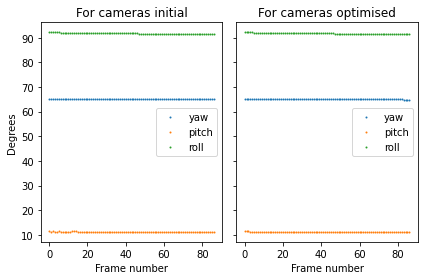

In [175]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].scatter(np.arange(len(for_optimised_pitch)),for_initial_yaw,label='yaw',s=1)
ax[0].scatter(np.arange(len(for_optimised_pitch)),for_initial_pitch,label='pitch',s=1)
ax[0].scatter(np.arange(len(for_optimised_pitch)),for_initial_roll,label='roll',s=1)

ax[1].scatter(np.arange(len(for_optimised_pitch)),for_optimised_yaw,label='yaw',s=1)
ax[1].scatter(np.arange(len(for_optimised_pitch)),for_optimised_pitch,label='pitch',s=1)
ax[1].scatter(np.arange(len(for_optimised_pitch)),for_optimised_roll,label='roll',s=1)

ax[0].set_title('For cameras initial')
ax[1].set_title('For cameras optimised')
ax[0].set_ylabel('Degrees')
ax[0].set_xlabel('Frame number')
ax[1].set_xlabel('Frame number')
ax[0].legend()
ax[1].legend()

plt.tight_layout()

In [176]:
def poly_resid(df, col, deg=2):
    """
    Written by David originally
    """
    poly_fit = np.poly1d(np.polyfit(df.index, df[col], deg))
    resid = poly_fit(df.index) - df[col]
    return resid

In [177]:
for_c2_100['init_yaw'] = for_initial_yaw
for_c2_100['init_pitch'] = for_initial_pitch
for_c2_100['init_roll'] = for_initial_roll

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [178]:
for_c2_100['opt_yaw'] = for_optimised_yaw
for_c2_100['opt_pitch'] = for_optimised_pitch
for_c2_100['opt_roll'] = for_optimised_roll

<AxesSubplot:>

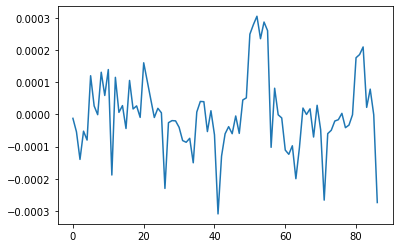

In [179]:
f,ax = plt.subplots()
poly_resid(for_c2_100,'opt_yaw',deg=3).plot(ax=ax)

<AxesSubplot:>

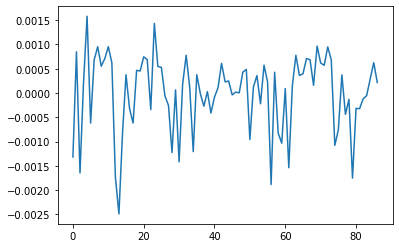

In [180]:
f,ax = plt.subplots()
poly_resid(for_c2_100,'init_yaw',deg=3).plot(ax=ax)

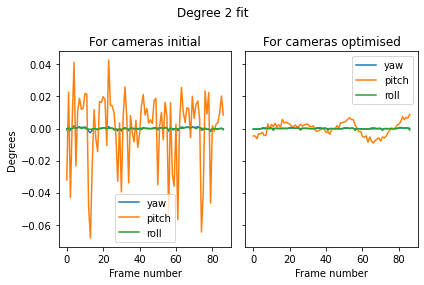

In [181]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
deg=2
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'init_yaw',deg=deg),label='yaw')
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'init_pitch',deg=deg),label='pitch')
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'init_roll',deg=deg),label='roll')

ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_yaw',deg=deg),label='yaw')
ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_pitch',deg=deg),label='pitch')
ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_roll',deg=deg),label='roll')

ax[0].set_title('For cameras initial')
ax[1].set_title('For cameras optimised')

ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Degrees')
ax[0].set_xlabel('Frame number')
ax[1].set_xlabel('Frame number')
plt.suptitle('Degree 2 fit')

plt.tight_layout()

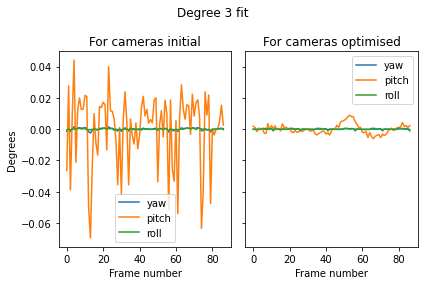

In [182]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
deg=3
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'init_yaw',deg=deg),label='yaw')
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'init_pitch',deg=deg),label='pitch')
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'init_roll',deg=deg),label='roll')

ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_yaw',deg=deg),label='yaw')
ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_pitch',deg=deg),label='pitch')
ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_roll',deg=deg),label='roll')

ax[0].set_title('For cameras initial')
ax[1].set_title('For cameras optimised')

ax[0].legend()
ax[1].legend()

ax[0].set_ylabel('Degrees')
ax[0].set_xlabel('Frame number')
ax[1].set_xlabel('Frame number')
plt.suptitle('Degree 3 fit')

plt.tight_layout()

#### Verify with ephemris estimate

In [183]:
r = R.from_quat(for_c2_100[['qx_ecef','qy_ecef','qz_ecef','qw_ecef']].values).as_euler('ZYX', degrees=True)

In [184]:
for_c2_100['ephem_yaw'] = r[:,0]
for_c2_100['ephem_pitch'] = r[:,1]
for_c2_100['ephem_roll'] = r[:,2]

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


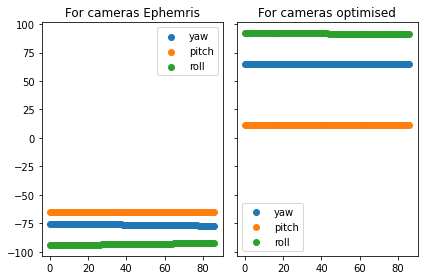

In [185]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].scatter(np.arange(len(for_optimised_pitch)),for_c2_100['ephem_yaw'],label='yaw')
ax[0].scatter(np.arange(len(for_optimised_pitch)),for_c2_100['ephem_pitch'],label='pitch')
ax[0].scatter(np.arange(len(for_optimised_pitch)),for_c2_100['ephem_roll'],label='roll')

ax[1].scatter(np.arange(len(for_optimised_pitch)),for_optimised_yaw,label='yaw')
ax[1].scatter(np.arange(len(for_optimised_pitch)),for_optimised_pitch,label='pitch')
ax[1].scatter(np.arange(len(for_optimised_pitch)),for_optimised_roll,label='roll')

ax[0].set_title('For cameras Ephemris')
ax[1].set_title('For cameras optimised')

ax[0].legend()
ax[1].legend()

plt.tight_layout()

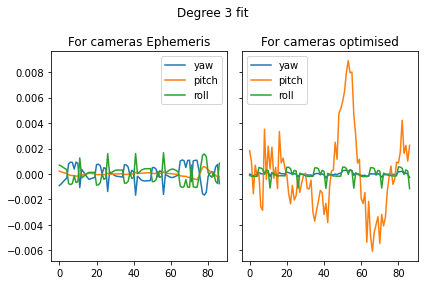

In [186]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
deg=3
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'ephem_yaw',deg=deg),label='yaw')
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'ephem_pitch',deg=deg),label='pitch')
ax[0].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'ephem_roll',deg=deg),label='roll')

ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_yaw',deg=deg),label='yaw')
ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_pitch',deg=deg),label='pitch')
ax[1].plot(np.arange(len(for_optimised_pitch)),poly_resid(for_c2_100,'opt_roll',deg=deg),label='roll')

ax[0].set_title('For cameras Ephemeris')
ax[1].set_title('For cameras optimised')

ax[0].legend()
ax[1].legend()
plt.suptitle('Degree 3 fit')

plt.tight_layout()

### Results for nadir cameras

In [187]:

nadir_camera_initial = [f'scipy_camera/{img}_scipy.tsai' for img in nadir_c2_100.name.values]
nadir_camera_opt = [f'c2_strip_full_sfm/run-{img}_scipy.tsai' for img in nadir_c2_100.name.values]

In [188]:
nadir_initial_rotation_angles = np.array([R.from_matrix(np.reshape(asp.read_tsai_dict(cam)['rotation_matrix'],(3,3))).as_euler('ZYX',degrees=True) for cam in nadir_camera_initial])
#nadir_initial_yaw = [r[0] for r in for_initial_rotation_angles]
#nadir_initial_pitch = [r[1] for r in for_initial_rotation_angles]
#nadir_initial_roll = [r[2] for r in for_initial_rotation_angles]

In [189]:
nadir_opt_rotation_angles = np.array([R.from_matrix(np.reshape(asp.read_tsai_dict(cam)['rotation_matrix'],(3,3))).as_euler('ZYX',degrees=True) for cam in nadir_camera_opt])


In [190]:
nadir_c2_100['init_yaw'] = nadir_initial_rotation_angles[:,0]
nadir_c2_100['init_pitch'] = nadir_initial_rotation_angles[:,1]
nadir_c2_100['init_roll'] = nadir_initial_rotation_angles[:,2]

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [191]:
nadir_c2_100['opt_yaw'] = nadir_opt_rotation_angles[:,0]
nadir_c2_100['opt_pitch'] = nadir_opt_rotation_angles[:,1]
nadir_c2_100['opt_roll'] = nadir_opt_rotation_angles[:,2]

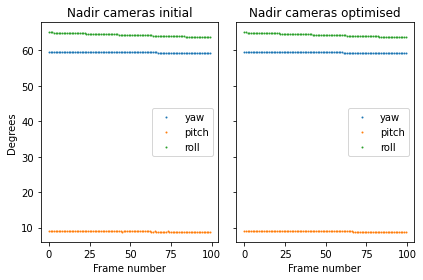

In [192]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].scatter(np.arange(len(nadir_c2_100)),nadir_c2_100['init_yaw'],label='yaw',s=1)
ax[0].scatter(np.arange(len(nadir_c2_100)),nadir_c2_100['init_pitch'],label='pitch',s=1)
ax[0].scatter(np.arange(len(nadir_c2_100)),nadir_c2_100['init_roll'],label='roll',s=1)

ax[1].scatter(np.arange(len(nadir_c2_100)),nadir_c2_100['opt_yaw'],label='yaw',s=1)
ax[1].scatter(np.arange(len(nadir_c2_100)),nadir_c2_100['opt_pitch'],label='pitch',s=1)
ax[1].scatter(np.arange(len(nadir_c2_100)),nadir_c2_100['opt_roll'],label='roll',s=1)

ax[0].set_title('Nadir cameras initial')
ax[1].set_title('Nadir cameras optimised')
ax[0].set_ylabel('Degrees')
ax[0].set_xlabel('Frame number')
ax[1].set_xlabel('Frame number')
ax[0].legend()
ax[1].legend()

plt.tight_layout()

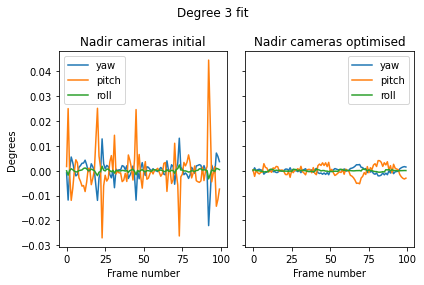

In [193]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
deg=3
ax[0].plot(np.arange(len(nadir_c2_100)),poly_resid(nadir_c2_100,'init_yaw',deg=deg),label='yaw')
ax[0].plot(np.arange(len(nadir_c2_100)),poly_resid(nadir_c2_100,'init_pitch',deg=deg),label='pitch')
ax[0].plot(np.arange(len(nadir_c2_100)),poly_resid(nadir_c2_100,'init_roll',deg=deg),label='roll')

ax[1].plot(np.arange(len(nadir_c2_100)),poly_resid(nadir_c2_100,'opt_yaw',deg=deg),label='yaw')
ax[1].plot(np.arange(len(nadir_c2_100)),poly_resid(nadir_c2_100,'opt_pitch',deg=deg),label='pitch')
ax[1].plot(np.arange(len(nadir_c2_100)),poly_resid(nadir_c2_100,'opt_roll',deg=deg),label='roll')

ax[0].set_title('Nadir cameras initial')
ax[1].set_title('Nadir cameras optimised')

ax[0].legend()
ax[1].legend()

ax[0].set_ylabel('Degrees')
ax[0].set_xlabel('Frame number')
ax[1].set_xlabel('Frame number')
plt.suptitle('Degree 3 fit')

plt.tight_layout()

In [126]:
r = R.from_quat(nadir_c2_100[['qx_ecef','qy_ecef','qz_ecef','qw_ecef']].values).as_euler('ZYX', degrees=True)

In [127]:
nadir_c2_100['ephem_yaw'] = r[:,0]
nadir_c2_100['ephem_pitch'] = r[:,1]
nadir_c2_100['ephem_roll'] = r[:,2]

/nobackupp11/sbhusha1/miniconda3/envs/bhushan_PY3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [169]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
nx = np.arange(len(nadir_c2_100))
ax[0].scatter(nx,nadir_c2_100['ephem_yaw'],label='yaw',s=1)
ax[0].scatter(nx,nadir_c2_100['ephem_pitch'],label='pitch',s=1)
ax[0].scatter(nx,nadir_c2_100['ephem_roll'],label='roll',s=1)

ax[1].scatter(nx,nadir_c2_100['opt_yaw'],label='yaw',s=1)
ax[1].scatter(nx,nadir_c2_100['opt_pitch'],label='pitch',s=1)
ax[1].scatter(nx,nadir_c2_100['opt_roll'],label='roll',s=1)

ax[0].set_title('Nadir cameras Ephemris')
ax[1].set_title('Nadir cameras optimised')

ax[0].legend()
ax[1].legend()

plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [148]:
f,ax = plt.subplots(subplot_kw={'projection': 'polar'})
az_for = np.deg2rad(for_c2_100['sat_az'])
el = 90 - for_c2_100['sat_elev']
ax.scatter(az_for, el, label='For', s=3)

az_for = np.deg2rad(nadir_c2_100['sat_az'])
el = 90 - nadir_c2_100['sat_elev']
ax.scatter(az_for, el, label='Nadir', s=3)

az_for = np.deg2rad(aft_c2_100['sat_az'])
el = 90 - aft_c2_100['sat_elev']
ax.scatter(az_for, el, label='Aft', s=3)


ax.set_rmin(0)
ax.set_rmax(70)

ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [167]:
nadir_c2_100['sat_az']

0     92.889712
1     92.926688
2     92.963614
3     93.000554
4     93.037576
        ...    
95    96.472926
96    96.511158
97    96.549417
98    96.587743
99    96.626085
Name: sat_az, Length: 100, dtype: float64

In [168]:
nadir_c2_100['sat_elev']

0     69.325179
1     69.328496
2     69.331799
3     69.335094
4     69.338411
        ...    
95    69.607372
96    69.609930
97    69.612481
98    69.615027
99    69.617565
Name: sat_elev, Length: 100, dtype: float64

In [153]:
from pyproj import Transformer

In [160]:
f,ax = plt.subplots()
for_df,nadir_df,aft_df = for_c2_100,nadir_c2_100,aft_c2_100
for_unary = gpd.GeoDataFrame({'idx':[0],'geometry':for_df.unary_union},crs='EPSG:32752')
ecef2utm = Transformer.from_crs('EPSG:4978','EPSG:32752')
sat_pos = ecef2utm.transform(for_df['x_sat_ecef_km']*1000,for_df['y_sat_ecef_km']*1000,for_df['z_sat_ecef_km']*1000) 
for_unary.plot(ax=ax,facecolor='blue')
ax.scatter(sat_pos[0],sat_pos[1],c='blue',s=1)
#ax.plot(for_df.unary_union)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [162]:
def plot_skysat_ground_space(gdf,ax,color,label):
    """
    Plot skysat footprint and space track
    """
    gdf_unary = gpd.GeoDataFrame({'idx':[0],'geometry':gdf.unary_union},crs=gdf.crs)
    ecef2utm = Transformer.from_crs('EPSG:4978',gdf.crs)
    sat_pos = ecef2utm.transform(gdf['x_sat_ecef_km']*1000,gdf['y_sat_ecef_km']*1000,gdf['z_sat_ecef_km']*1000)
    gdf_unary.plot(ax=ax,facecolor=color)
    ax.scatter(sat_pos[0],sat_pos[1],c=color,s=3,label=label)
    

In [171]:
f,ax = plt.subplots(figsize=(5,8))
plot_skysat_ground_space(for_c2_100,ax,'blue',label='Forward')
plot_skysat_ground_space(nadir_c2_100,ax,'green',label='Nadir')
plot_skysat_ground_space(aft_c2_100,ax,'red',label='Aft')
ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [173]:
nadir_opt_rotation_angles[:,2]

array([65.09796618, 65.08391004, 65.07025616, 65.05636959, 65.04247575,
       65.02867047, 65.0147649 , 65.00110459, 64.9870368 , 64.97306596,
       64.95897768, 64.94422497, 64.93020387, 64.91646337, 64.90288453,
       64.88875047, 64.87486911, 64.86089763, 64.84711182, 64.83323477,
       64.81931917, 64.80531356, 64.79136866, 64.77748395, 64.76333953,
       64.74958355, 64.73471559, 64.7208159 , 64.7069307 , 64.69340812,
       64.67912294, 64.66534909, 64.65132645, 64.63742653, 64.62347557,
       64.60974667, 64.5958265 , 64.58186922, 64.5677865 , 64.55396405,
       64.53979802, 64.52492504, 64.51121508, 64.49735228, 64.48371378,
       64.46956745, 64.45558363, 64.44181165, 64.4278216 , 64.41405374,
       64.39989546, 64.38600297, 64.3719427 , 64.35786239, 64.34390461,
       64.32994919, 64.31516389, 64.30113403, 64.28730767, 64.27355082,
       64.25947616, 64.24551722, 64.23161263, 64.21760903, 64.20367373,
       64.18971783, 64.175672  , 64.16160326, 64.14759534, 64.13

In [196]:
def df2gdf(df):
    df = df.rename(columns={'# lon':'lon',' lat':'lat',' height_above_datum':'height_above_datum',' mean_residual':'mean_residual'})
    df['geometry'] = df.apply(point_convert, axis=1)
    gdf = gpd.GeoDataFrame(df,geometry='geometry',crs='epsg:4326')
    gdf = gdf.to_crs('epsg:3857')
    gdf = gdf.sort_values('mean_residual',ascending=True)
    return gdf
def point_convert(row):
    from shapely.geometry import Point
    geom = Point(row['lon'],row['lat'])
    return geom

In [197]:
reproj_error = df2gdf(pd.read_csv('c2_strip_full_sfm/run-final_residuals_no_loss_function_pointmap_point_log.csv',skiprows=[1]))

In [198]:
reproj_error.describe()

,lon,lat,height_above_datum,mean_residual,num_observations
count,18506.000000,18506.000000,18506.000000,18506.000000,18506.00000
mean,131.037868,-25.311189,529.609169,0.258206,13.39090
std,0.006973,0.016362,225.024069,0.681506,13.61786
min,131.020623,-25.345044,-1810.287553,0.000007,2.00000
25%,131.031874,-25.325282,518.106649,0.073679,2.00000
50%,131.037683,-25.314598,519.998559,0.118696,7.00000
75%,131.043678,-25.296068,524.095556,0.154662,22.00000
max,131.054590,-25.275839,3677.853174,4.998339,52.00000
